In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [44]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [45]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=2*x**2+3*torch.sin(torch.pi*x/2.4)*x*(1-torch.exp(-x/6))
    return poten

In [46]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [47]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =20
L=Lb-La  # domain length
N = 800   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=2
scale=10

en_num=20
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [48]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [49]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:80.40233612060547,time:0.01652669906616211,lr:0.01
epoch:10,loss:15.423726081848145,time:0.18181586265563965,lr:0.01
epoch:20,loss:7.445908546447754,time:0.3491816520690918,lr:0.01
epoch:30,loss:6.9923906326293945,time:0.5086703300476074,lr:0.01
epoch:40,loss:3.7632150650024414,time:0.6631979942321777,lr:0.01
epoch:50,loss:2.655742645263672,time:0.8202164173126221,lr:0.01
epoch:60,loss:2.1260550022125244,time:0.9725363254547119,lr:0.01
epoch:70,loss:7.606181621551514,time:1.1286981105804443,lr:0.01
epoch:80,loss:4.3340935707092285,time:1.2940454483032227,lr:0.01
epoch:90,loss:5.186827182769775,time:1.460158348083496,lr:0.01
epoch:100,loss:2.7284045219421387,time:1.626145601272583,lr:0.01
epoch:110,loss:4.972038745880127,time:1.788557767868042,lr:0.01
epoch:120,loss:1.926896095275879,time:1.9496591091156006,lr:0.01
epoch:130,loss:2.7147879600524902,time:2.1075282096862793,lr:0.01
epoch:140,loss:3.7448763847351074,time:2.270164728164673,lr:0.01
epoch:150,loss:1.6678938865661

In [50]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

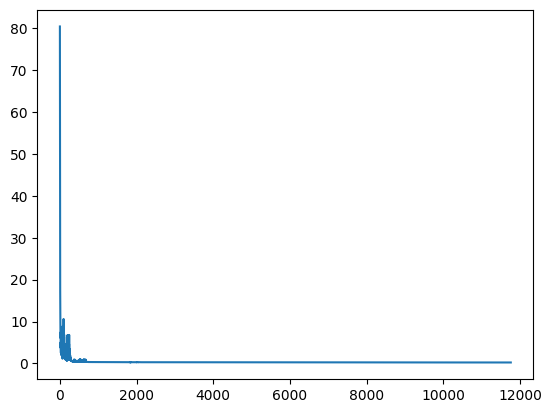

In [51]:
plt.plot(loss_list)
plt.show()

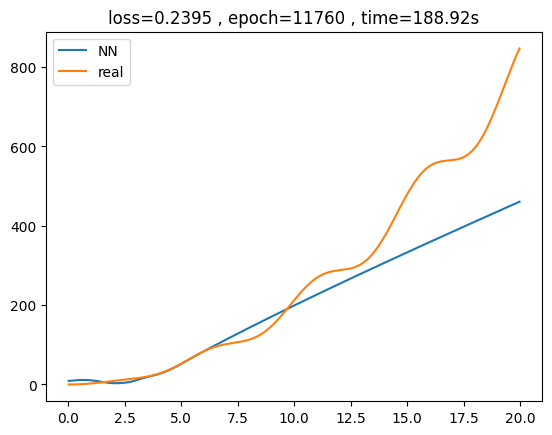

In [57]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


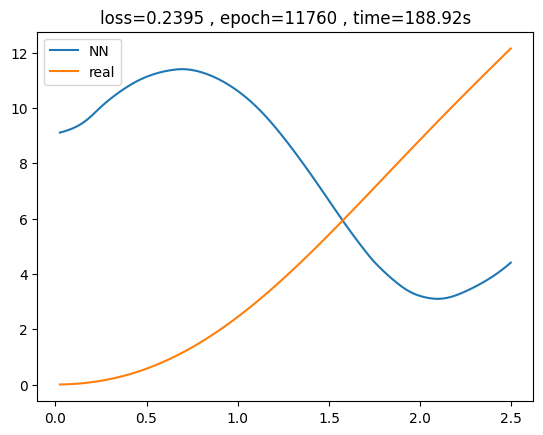

In [53]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:100]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [54]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([ 1.9540e+00,  1.6696e+00,  9.0369e-01, -1.0490e-05, -5.4943e-02,
         2.3766e-03, -6.6395e-03,  9.6893e-04, -1.2062e-02,  4.2572e-03,
        -1.4763e-03,  1.0986e-03, -4.6883e-03, -4.5776e-05,  9.1553e-04,
         4.2152e-03,  3.2578e-03, -7.6828e-03, -9.3613e-03,  1.0475e-02],
       device='cuda:2', grad_fn=<SubBackward0>)
relative error: tensor([ 5.9396e-01,  2.1982e-01,  7.8726e-02, -7.0193e-07, -3.0104e-03,
         1.0981e-04, -2.6347e-04,  3.3489e-05, -3.6740e-04,  1.1545e-04,
        -3.5961e-05,  2.4230e-05, -9.4282e-05, -8.4477e-07,  1.5594e-05,
         6.6619e-05,  4.8007e-05, -1.0605e-04, -1.2156e-04,  1.2848e-04],
       device='cuda:2', grad_fn=<DivBackward0>)


energy level while l=0


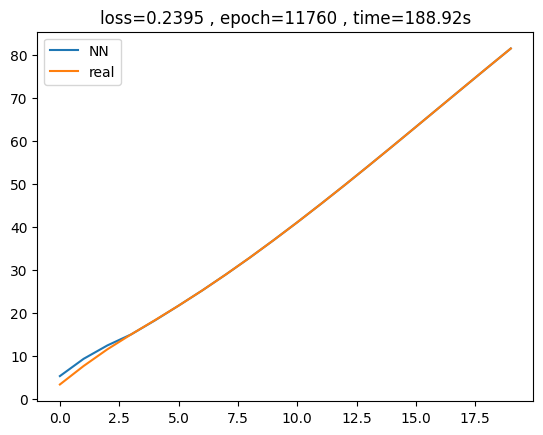

In [55]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

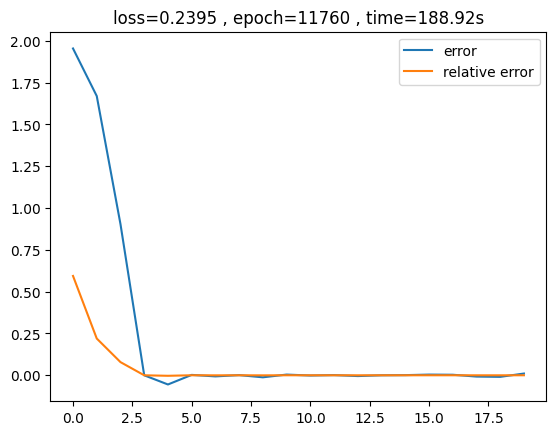

In [56]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()